# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
datdir = os.getenv("PUIDATA") + "/Lab9" # On my local machine
# datdir = os.getenv("HOME") + "/PUIdata" # For use on compute where the PUIDATA variable is unavailable
shape_path = datdir + "/Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

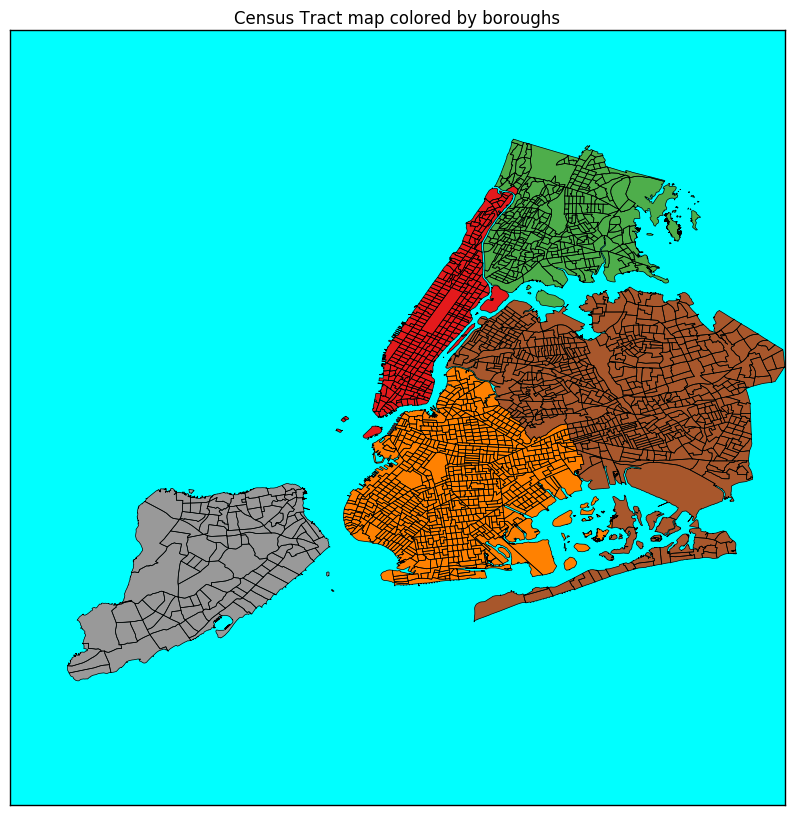

In [5]:
plt.rcParams['axes.facecolor'] = 'aqua'
f, ax = plt.subplots(figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha=1, linewidth=0.5, ax=ax)
plt.title("Census Tract map colored by boroughs")

Figure 1. The census tracts of New York City colored by borough.

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data = DataFrame.from_csv(datdir + '/Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
#SE_T002_002 is population density in social explorer dataset
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']])

#### Vusualize the Population density for 2010

/home/scott/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


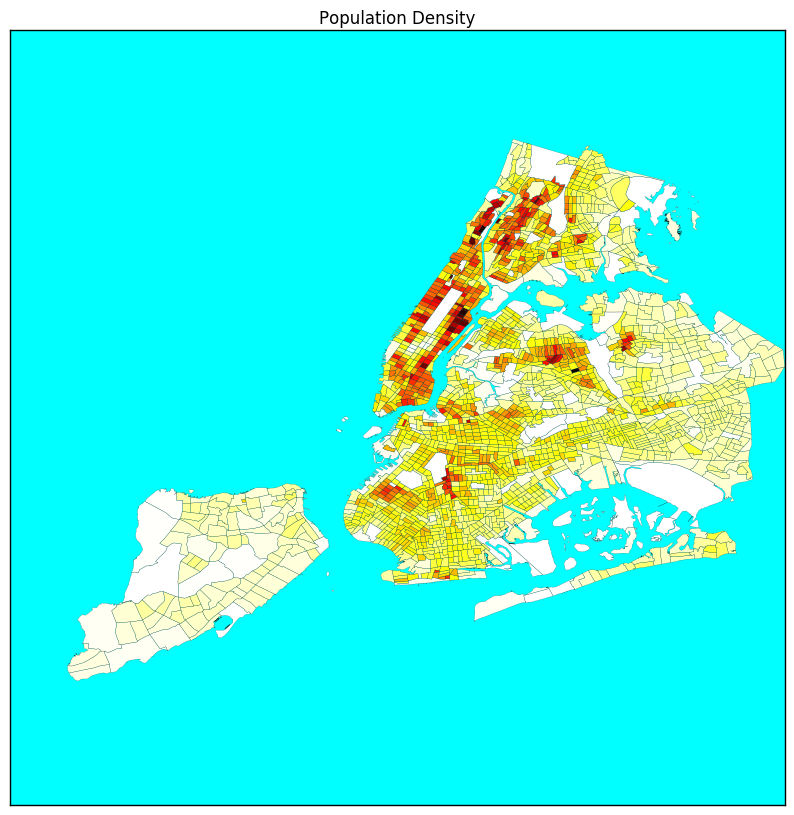

In [8]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from geopandas.plotting import norm_cmap
f, ax = plt.subplots(figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax)
"""
# Use parts of a procedure linked from stackoverflow to produce a legend
# Full procedure is at http://nbviewer.jupyter.org/gist/jorisvandenbossche/d4e6efedfa1e4e91ab65
# Unfortunately, there are too many unique colors to make a printable legend, so will just have to do
# without the legend
l_categories = list(set(ct_shape_pop['SE_T002_002'].values))
l_categories.sort()
l_valuemap = dict([(k, v) for (v, k) in enumerate(l_categories)])
l_values = []
for k in ct_shape_pop['SE_T002_002']:
    if k >= 0:
        l_values.append(l_valuemap[k])
l_patches = []
l_cmap = norm_cmap(l_values, 'hot_r', Normalize, cm)
lastmark = None
l_cats = []
newcat = []
for value, cat in enumerate(l_categories):
    markcol = l_cmap.to_rgba(value)
    if markcol != lastmark:
        print(markcol)
        if lastmark != None:
            l_patches.append(Line2D([0], [0], linestyle='none', marker='o', alpha=1,
                                   markersize=10, markerfacecolor=lastmark))
            l_cats.append(str(newcat[0]) + " - " + str(newcat[1]))
        newcat = [value, value]
        lastmark = markcol
    newcat[1] = value
l_patches.append(Line2D([0], [0], linestyle='none', marker='o', alpha=1,
                       markersize=10, markerfacecolor=lastmark))
l_cats.append(str(newcat[0]) + " - " + str(newcat[1]))
plt.legend(l_patches, l_cats, numpoints=1, loc='best')
"""
plt.title("Population Density")

Figure 2. Census tracts of New York City colored by population density.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly = DataFrame.from_csv(datdir + '/Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


Table 1a. The monthly ride totals by station number.

In [10]:
df_bike_monthly_nan = df_bike_monthly.replace(0, np.nan)
df_bike_monthly_nan.head(5)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914.0,6979,2750,4914,2229,2183,3139,3622.0,2368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,2696,4429.0,9020,3433,6645,2768,2761,3422,4271.0,2910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-30,2878,5258.0,9814,3739,7837,3206,2747,3590,4618.0,2885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-31,2920,4409.0,10456,3520,8928,3237,2530,3909,4169.0,2542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-30,1883,2731.0,6384,2446,5201,2085,1415,2727,3146.0,1539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table 1b. The monthly ride totals by station number with 0s replaced with NaN. This will allow calculating averages that exclude months for which the station was not in use.

### Time Series Aanalysis

In [11]:
df_bike_monthly_nan.tail(5)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2016-02-29,1200,1951.0,4913,2088,2503,2224,859,2814,NaN,1082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,1891,3181.0,7721,2529,4586,3692,1633,4015,NaN,1894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,2388,3833.0,7666,3219,5327,4157,1794,4169,NaN,1928,...,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,2808,6253.0,9246,4317,5920,5033,2109,5179,NaN,2459,...,901.0,62.0,20.0,2859.0,394.0,NaN,NaN,NaN,NaN,NaN
2016-06-30,3399,7370.0,10130,4566,7420,5775,2429,6037,NaN,3054,...,1036.0,NaN,NaN,7009.0,1109.0,665.0,2470.0,178.0,852.0,615.0


Table 1c. Monthly ride totals by station number at the end of the time period.

/home/scott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

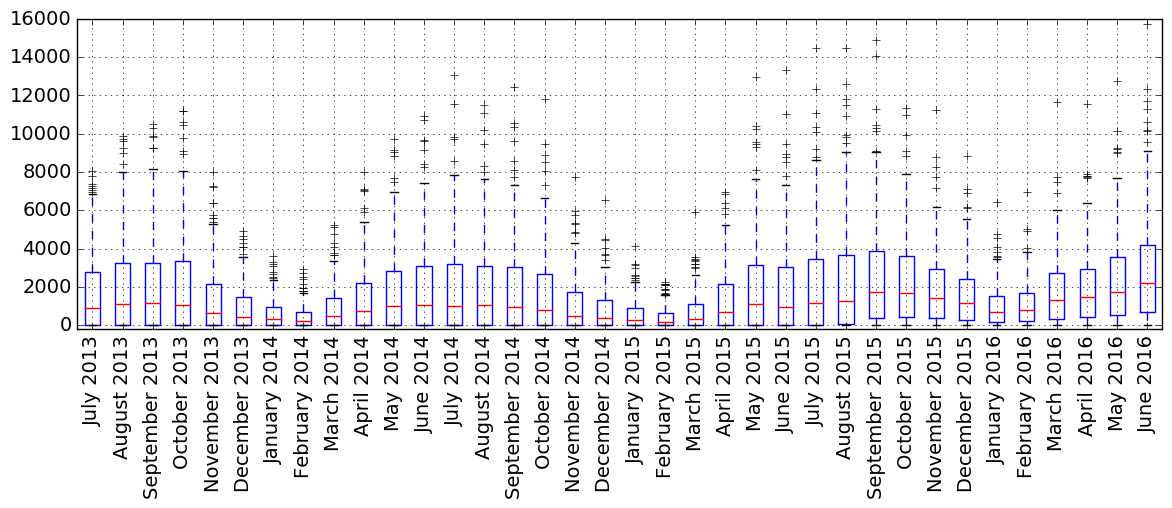

In [12]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize=(14, 4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15, 7), ax=ax, rot=90);
ax.set_ylim([-200, 16000])

Figure 3. Bar chart showing ridership by month.

#### Seasonal Decomposition

/home/scott/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


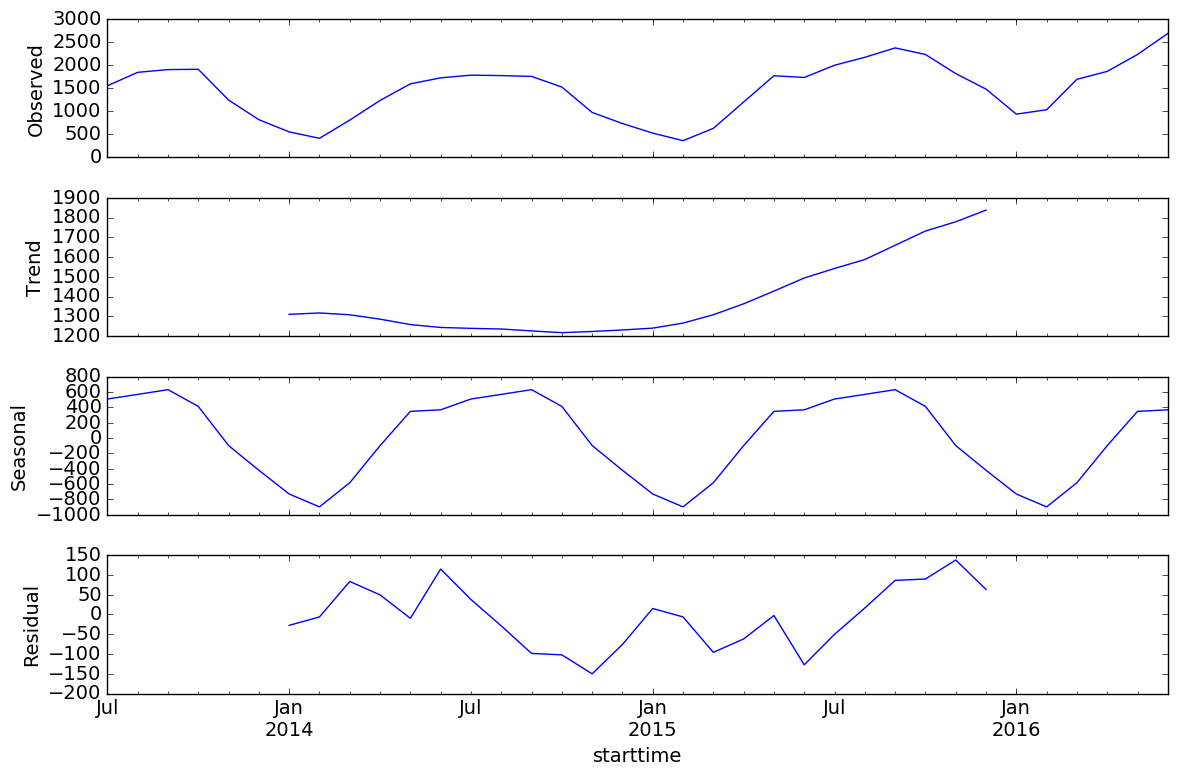

In [13]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 4. Breaking apart the components of monthly ridership: trend or year-to-year growth, seasonal variation, and residual.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [14]:
station_id = DataFrame.from_csv(datdir + '/Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


Table 2. Coordinates of the first 5 stations.

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [15]:
import shapely
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


Table 3. Coordinates of the first 5 stations converted to type geometric point.

### Intersect the two geometries

In [16]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%", str((i + 1) * 100. / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()
station_id['MonthlyMean'] = df_bike_monthly_nan.mean(skipna=True)

In [19]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,MonthlyMean
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,1925.222222
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,3213.250000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,7597.916667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,2831.916667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,5112.333333


Table 4. First 5 stations with coordinate, borough/census tract, total rides, and average monthly rides.

### Add the monthly average rides to the CT shapefile 

In [20]:
# use the 
temp = station_id[['MonthlyAve', 'MonthlyMean']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0, inplace=True)

/home/scott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


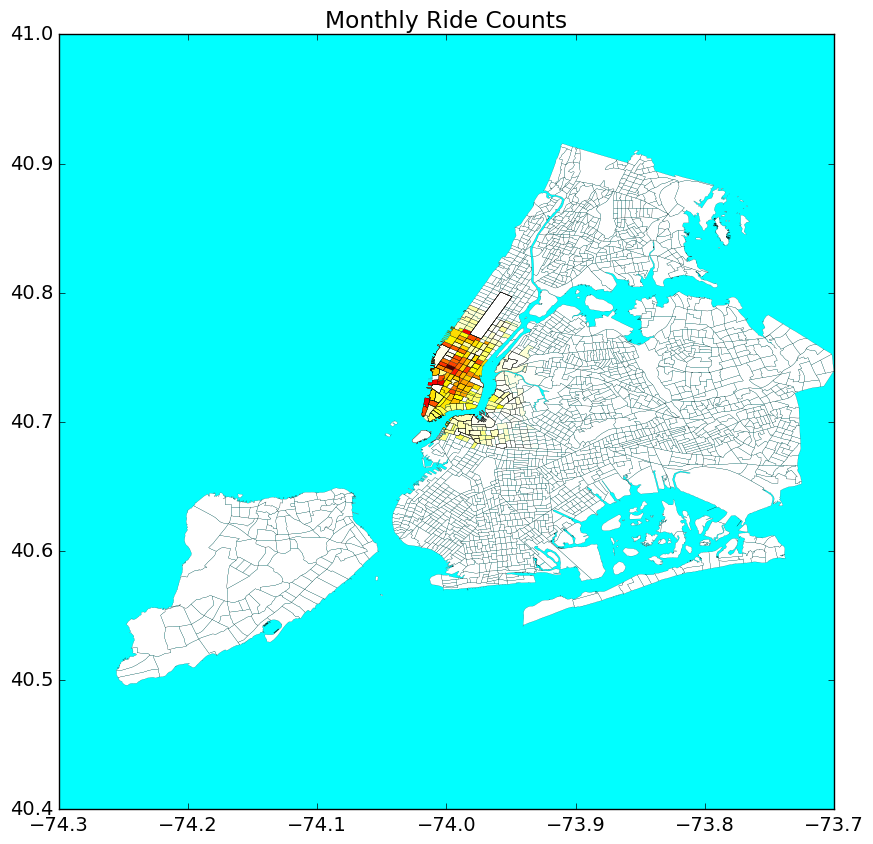

In [21]:
plt.rcParams['axes.facecolor'] = 'aqua'
f, ax = plt.subplots(figsize=(10, 10))
ct_shape_MonthlyAve.plot(column='MonthlyAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax)
plt.title("Monthly Ride Counts")

Figure 5. Total rides by tract showing the extent of the full city.

### Removing the CTs that are out of zoom boundries

In [22]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [23]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

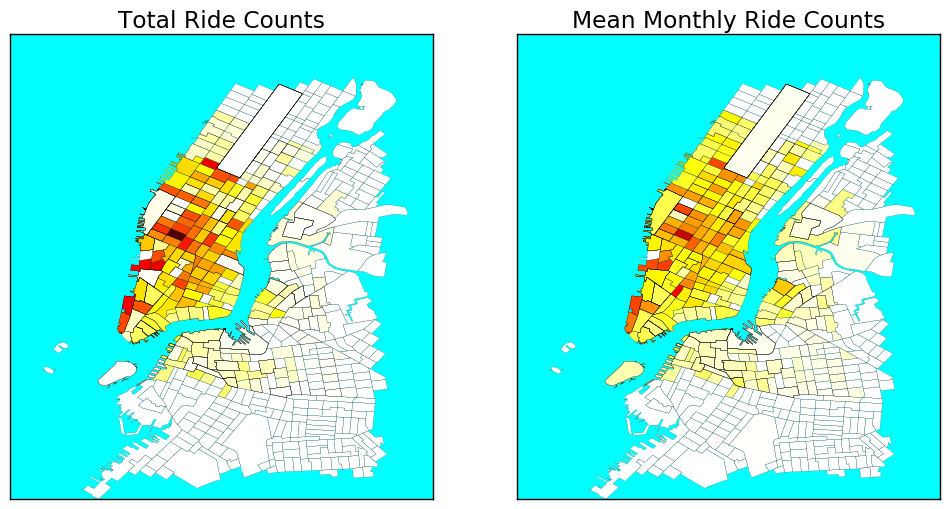

In [24]:
axs = [None, None]
collist = ['MonthlyAve', 'MonthlyMean']
desclist = ['Total Ride Counts', 'Mean Monthly Ride Counts']
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(12, 6))
for i in 0, 1:
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    ct_shape_MonthlyAve_Zoom.plot(column=collist[i], colormap='hot_r', alpha=1, linewidth=0.1, ax=axs[i])
    axs[i].set_title(desclist[i])

Figure 6. Total ride counts (left) and average ride counts (right) by census tract. 

### Export Shapefile CTs in the CitiBike Zone

In [25]:
path = datdir + '/Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [26]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [27]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [28]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [29]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [30]:
Wmatrix, ids = qW_CT.full()

In [31]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [32]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [33]:
MonthlyRide = {}
MonthlyRideLag = {}
for k in "MonthlyAve", "MonthlyMean":
    MonthlyRide[k] = ct_shape_MonthlyAve_Zoom[k]
    MonthlyRideLag[k] = ps.lag_spatial(qW_CT, MonthlyRide[k])

#### Create Quantiles for maping

In [34]:
MonthlyRideLagQ10 = {}
for typ in MonthlyRide.keys():
    MonthlyRideLagQ10[typ] = ps.Quantiles(MonthlyRideLag[typ], k=10)
MonthlyRideLagQ10

{'MonthlyAve':                     Quantiles                    
  
   Lower                Upper                Count
              x[i] <=      0.000               140
      0.000 < x[i] <=    237.571                21
    237.571 < x[i] <=   4167.561                78
   4167.561 < x[i] <=  10026.857                80
  10026.857 < x[i] <=  17493.404                79
  17493.404 < x[i] <=  26977.053                80
  26977.053 < x[i] <=  58126.278                79
  58126.278 < x[i] <=  81788.042                80
  81788.042 < x[i] <=  96870.015                79
  96870.015 < x[i] <= 151983.357                80,
 'MonthlyMean':                   Quantiles                  
  
  Lower              Upper               Count
            x[i] <=    0.000               140
    0.000 < x[i] <=   21.597                21
   21.597 < x[i] <=  258.428                78
  258.428 < x[i] <=  531.674                80
  531.674 < x[i] <=  889.908                79
  889.908 < x[i] <= 148

#### Map the monthly rides lag

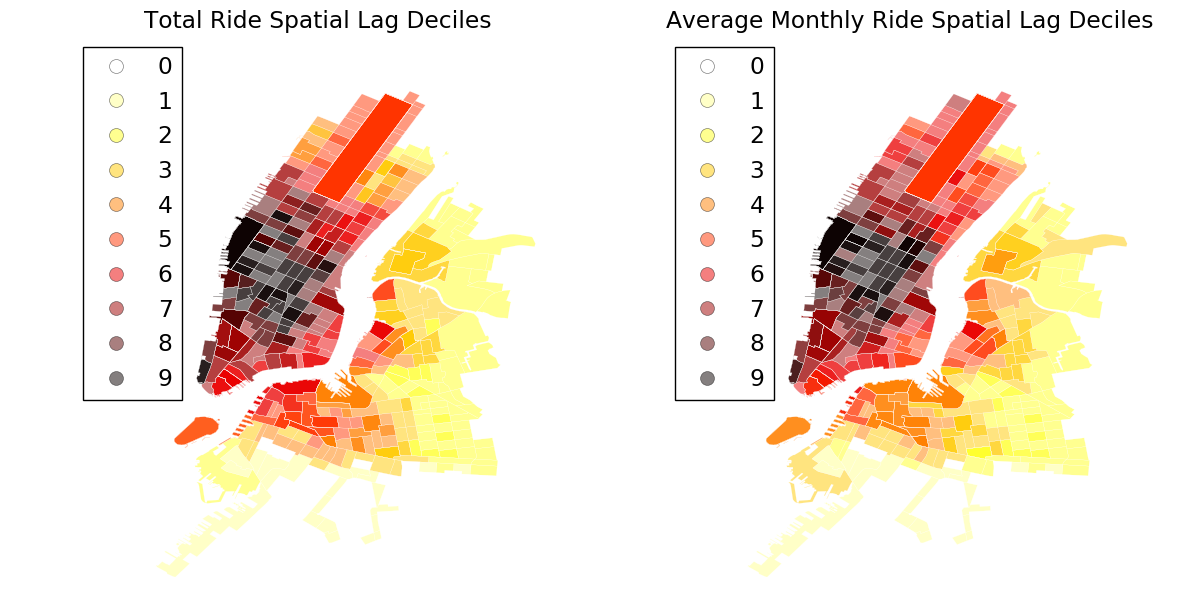

In [35]:
plt.rcParams['legend.facecolor'] = 'white'
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10[collist[i]].yb).plot(column='cl', categorical=True, 
            k=10, cmap='hot_r', linewidth=0.1, ax=axs[i], 
            edgecolor='white', legend=True)
    axs[i].set_axis_off()
axs[0].set_title("Total Ride Spatial Lag Deciles")
axs[1].set_title("Average Monthly Ride Spatial Lag Deciles")


Figure 7. Spatial lag deciles by total rides (left) and by average monthly rides (right).

## Global  Spatial Autocorrelation

In [36]:
b = {}
a = {}
for typ in collist:
    b[typ], a[typ] = np.polyfit(MonthlyRide[typ], MonthlyRideLag[typ], 1)
b, a 

({'MonthlyAve': 0.65563669282948489, 'MonthlyMean': 0.6633761434632659},
 {'MonthlyAve': 12557.637062387883, 'MonthlyMean': 469.10681449419673})

### Moran Scatterplot

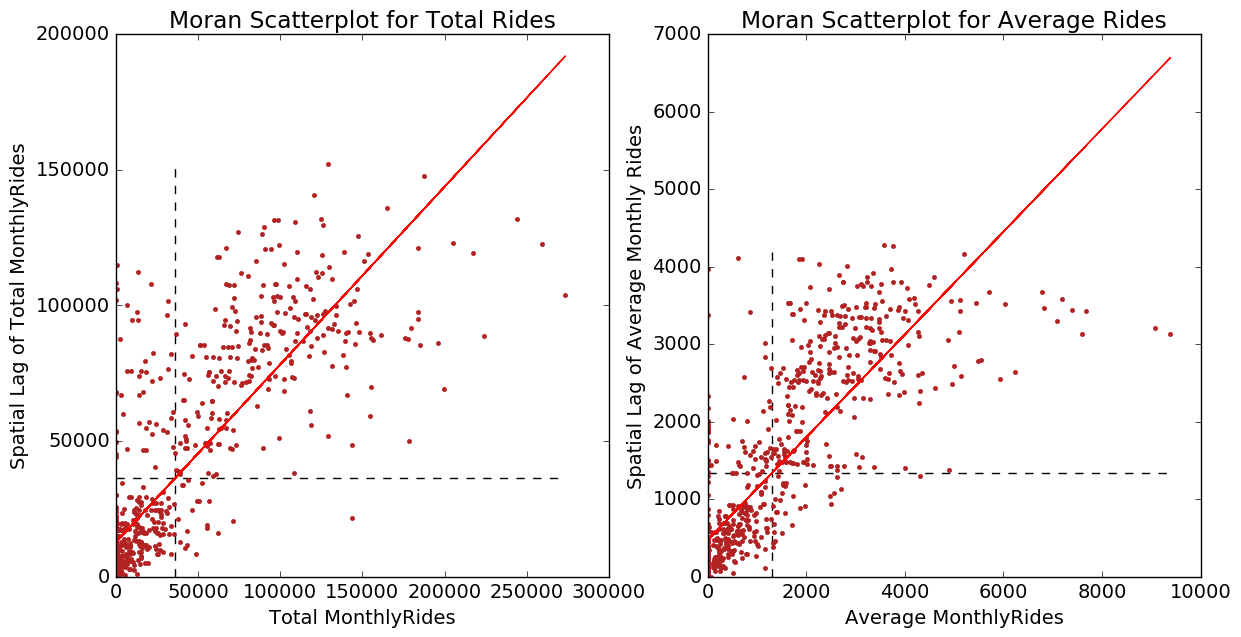

In [37]:
plt.rcParams['axes.facecolor'] = 'white'
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))

for i in 0, 1:
    axs[i].plot(MonthlyRide[collist[i]], MonthlyRideLag[collist[i]], '.', color='firebrick')

    # dashed vert at mean of the last year's PCI
    axs[i].vlines(MonthlyRide[collist[i]].mean(), MonthlyRideLag[collist[i]].min(),
                  MonthlyRideLag[collist[i]].max(), linestyle='--')
    # dashed horizontal at mean of lagged PCI
    axs[i].hlines(MonthlyRideLag[collist[i]].mean(), MonthlyRide[collist[i]].min(),
                  MonthlyRide[collist[i]].max(), linestyle='--')

    # red line of best fit using global I as slope
    axs[i].plot(MonthlyRide[collist[i]], a[collist[i]] + b[collist[i]] * MonthlyRide[collist[i]], 'r')
axs[0].set_ylabel('Spatial Lag of Total MonthlyRides')
axs[0].set_xlabel('Total MonthlyRides')
axs[0].set_title('Moran Scatterplot for Total Rides')
axs[1].set_ylabel('Spatial Lag of Average Monthly Rides')
axs[1].set_xlabel('Average MonthlyRides')
axs[1].set_title("Moran Scatterplot for Average Rides")

Figure 8. Scatter plots of monthly rides against spatial lag of monthly rides with a trend line based on Moran's I for total rides (left) and average monthly rides (right).

### Moran's I

In [38]:
I_MonthlyRide = {}
for typ in collist:
    I_MonthlyRide[typ] = ps.Moran(MonthlyRide[typ], qW_CT)

In [39]:
for typ in collist:
    print(typ)
    print(I_MonthlyRide[typ].I, I_MonthlyRide[typ].p_sim)

MonthlyAve
(0.65579332908409083, 0.001)
MonthlyMean
(0.66331249816669924, 0.001)


Thus, the $I$ statistic is $0.656$ for the total rides and $0.663$ for average rides. Both have a very small $p$ value. 

In [40]:
for typ in collist:
    print(typ)
    print(I_MonthlyRide[typ].sim[0:10])

MonthlyAve
[-0.01520816  0.00573052 -0.03344507  0.00941727 -0.03782455  0.02220805
  0.0106168  -0.00600334  0.02165303 -0.00655404]
MonthlyMean
[-0.03105614  0.00405365 -0.02128486  0.01705184 -0.00084987 -0.02468355
 -0.00427853 -0.01610675  0.03093215  0.02143997]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [41]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

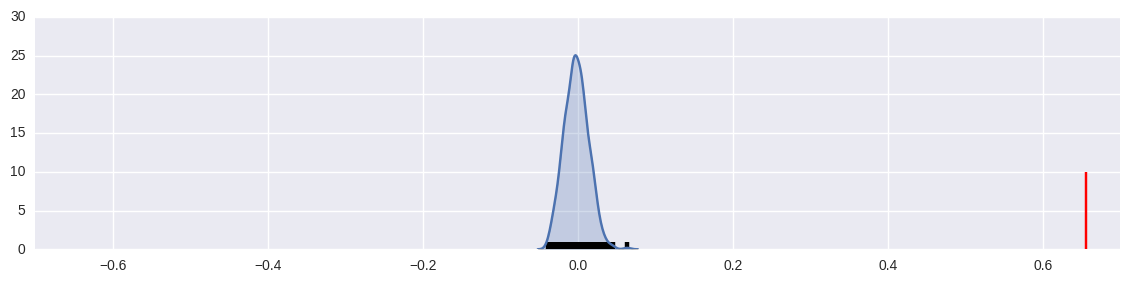

In [42]:
sns.kdeplot(I_MonthlyRide[collist[0]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[0]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[0]].I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 9a. Kernel density plot for total ridership.

(-0.7, 0.7)

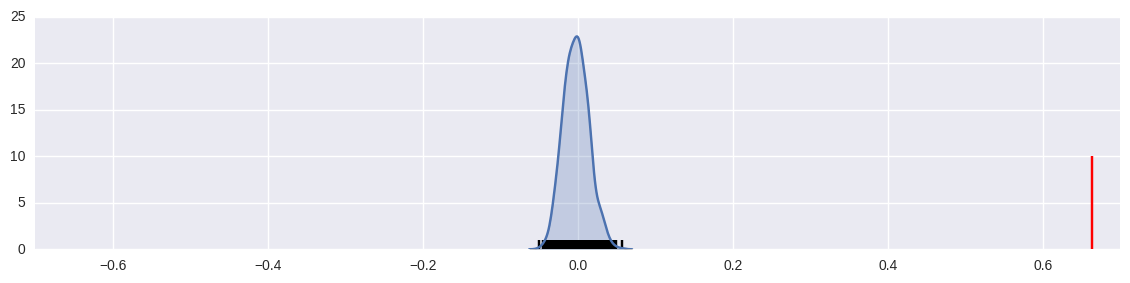

In [43]:
sns.kdeplot(I_MonthlyRide[collist[1]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[1]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[1]].I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 9b. Kernel density plot for average monthly ridership.

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

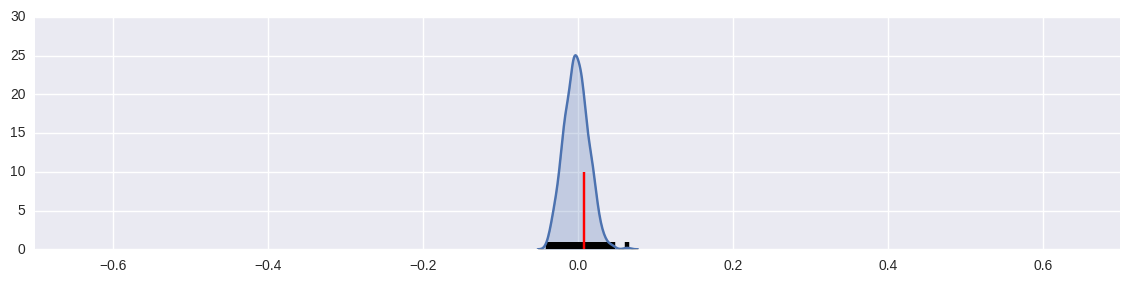

In [44]:
sns.kdeplot(I_MonthlyRide[collist[0]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[0]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[0]].EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 10a. Moran's $I$ fits within expected value for total rides.

(-0.7, 0.7)

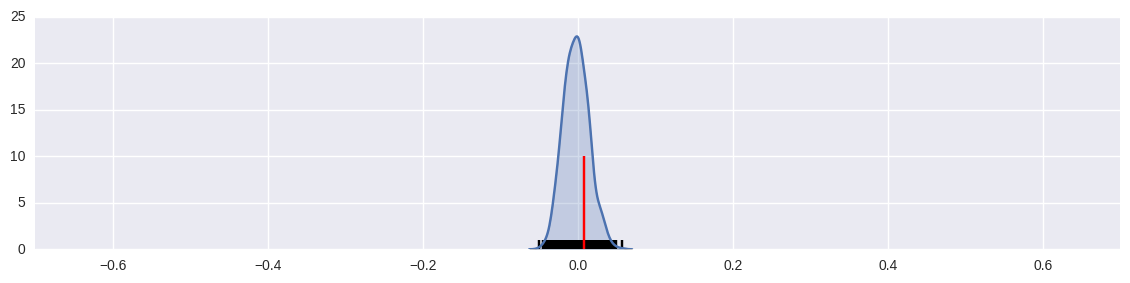

In [45]:
sns.kdeplot(I_MonthlyRide[collist[1]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[1]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[1]].EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 10b. Moran's $I$ fits within expected value for average rides.

## Local  Spatial Autocorrelation

In [46]:
LMo_MonthlyRide = {}
for typ in collist:
    LMo_MonthlyRide[typ] = ps.Moran_Local(MonthlyRide[typ], qW_CT, permutations=999)

In [47]:
for typ in collist:
    print(LMo_MonthlyRide[typ].Is[0:5], LMo_MonthlyRide[typ].p_sim[0:5])

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]), array([ 0.001,  0.143,  0.38 ,  0.397,  0.434]))
(array([-0.        , -0.10815469,  0.01938585,  0.01923704, -0.04787734]), array([ 0.001,  0.34 ,  0.365,  0.325,  0.312]))


### LISA (Local Indicators of Spatial Autocorrelation)

In [48]:
sigs = {}
W_sigs = {}
insigs = {}
W_insigs = {}
for typ in collist:
    sigs[typ] = MonthlyRide[typ][LMo_MonthlyRide[typ].p_sim <= .001]
    W_sigs[typ] = MonthlyRideLag[typ][LMo_MonthlyRide[typ].p_sim <= .001]
    insigs[typ] = MonthlyRide[typ][LMo_MonthlyRide[typ].p_sim > .001]
    W_insigs[typ] = MonthlyRideLag[typ][LMo_MonthlyRide[typ].p_sim > .001]

### Plot Signficant LISA

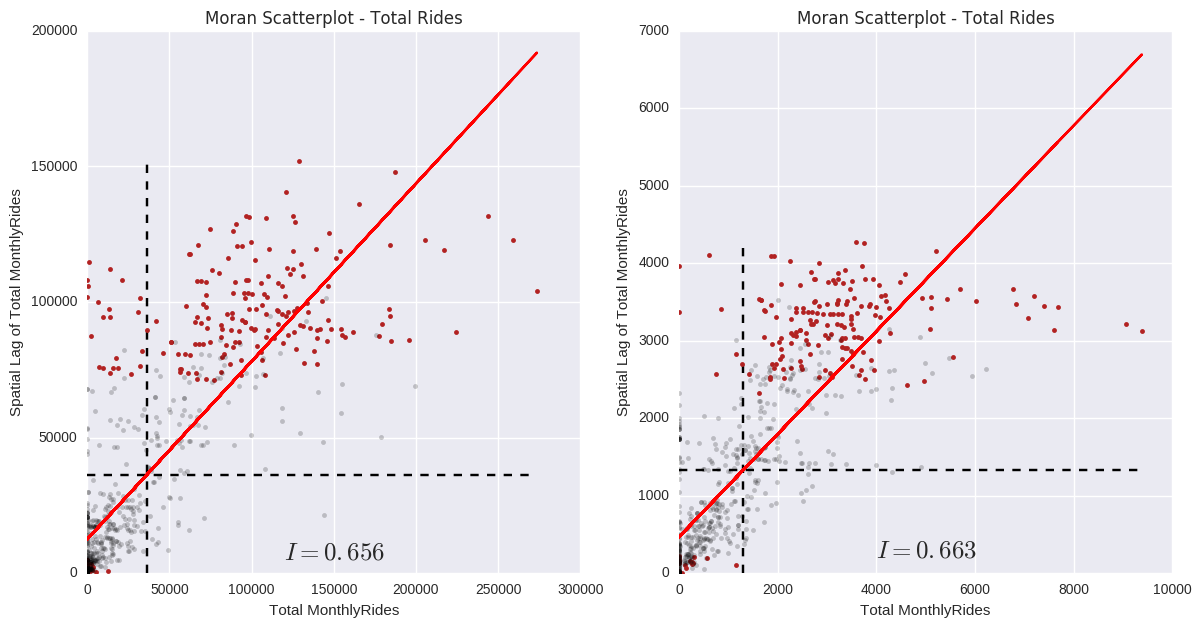

In [49]:
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    typ = collist[i]
    axs[i].plot(sigs[typ], W_sigs[typ], '.', color='firebrick')
    axs[i].plot(insigs[typ], W_insigs[typ], '.k', alpha=.2)

    # dashed vert at mean of the last year's PCI
    axs[i].vlines(MonthlyRide[typ].mean(), MonthlyRideLag[typ].min(), MonthlyRideLag[typ].max(), linestyle='--')
    # dashed horizontal at mean of lagged PCI
    axs[i].hlines(MonthlyRideLag[typ].mean(), MonthlyRide[typ].min(), MonthlyRide[typ].max(), linestyle='--')

    # red line of best fit using global I as slope
    axs[i].plot(MonthlyRide[typ], a[typ] + b[typ] * MonthlyRide[typ], 'r')

axs[0].set_title('Moran Scatterplot - Total Rides')
axs[0].set_ylabel('Spatial Lag of Total MonthlyRides')
axs[0].set_xlabel('Total MonthlyRides')
axs[0].text(s='$I = %.3f$' % I_MonthlyRide[collist[0]].I, x=120000, y=5000, fontsize=18)
axs[1].set_title('Moran Scatterplot - Total Rides')
axs[1].set_ylabel('Spatial Lag of Total MonthlyRides')
axs[1].set_xlabel('Total MonthlyRides')
axs[1].text(s='$I = %.3f$' % I_MonthlyRide[collist[1]].I, x=4000, y=200, fontsize=18)


Figure 11. Moran scatterplot showing hot tracts in red and cold tracts in grey for total rides (left) and average monthly rides (right).

### Hot and Cold spots 

In [50]:
sig = {}
hotspots = {}
coldspots = {}
for typ in collist:
    sig[typ] = LMo_MonthlyRide[typ].p_sim < 0.01
    hotspots[typ] = LMo_MonthlyRide[typ].q == 1 * sig[typ]
    coldspots[typ] = LMo_MonthlyRide[typ].q == 3 * sig[typ]
    print "Number of ", typ, " Hotspots:", hotspots[typ].sum()
    print "Number of ", typ, " Coldspots:", coldspots[typ].sum()

Number of  MonthlyAve  Hotspots: 193
Number of  MonthlyAve  Coldspots: 231
Number of  MonthlyMean  Hotspots: 218
Number of  MonthlyMean  Coldspots: 212


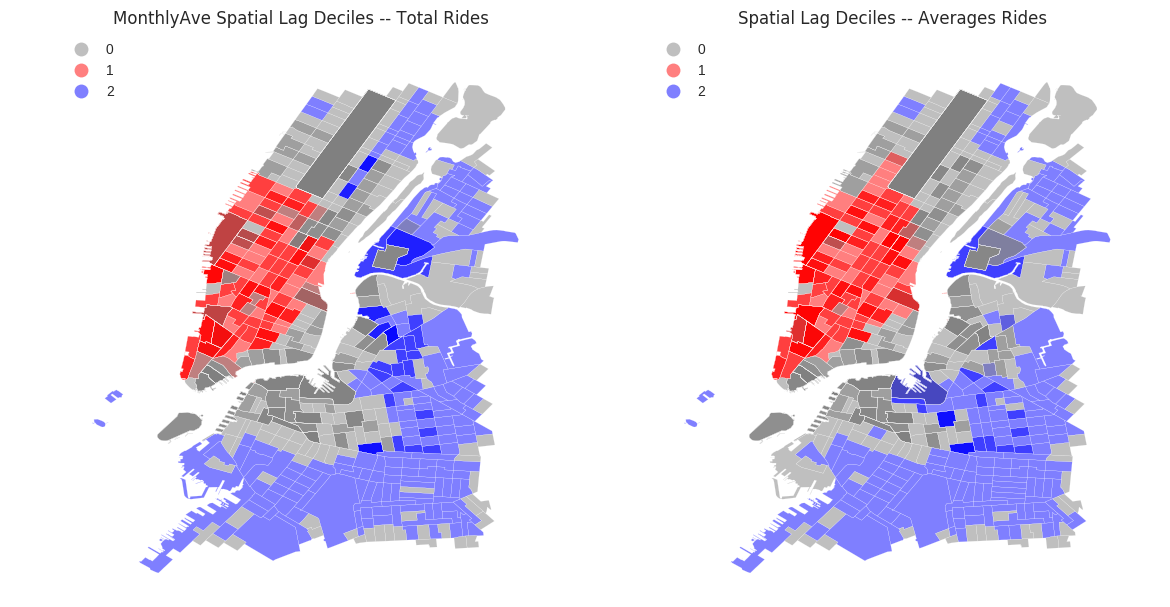

In [51]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    typ = collist[i]
    hotcold = hotspots[typ] * 1 + coldspots[typ] * 2

    ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
            k=10, cmap=hcmap, linewidth=0.1, ax=axs[i], 
            edgecolor='white', legend=True)
    axs[i].set_axis_off()
axs[0].set_title("MonthlyAve Spatial Lag Deciles -- Total Rides")
axs[1].set_title("Spatial Lag Deciles -- Averages Rides")

Figure 12. Hot/cold spot maps for total ridership (left) and average monthly ridership (right) by tract.